In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_clean.csv')
train_clean.head()

,Unnamed: 0,qid,question_text,target,clean_text
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist see province nation
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt shop
2,2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemisphere
4,4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


In [ ]:
#some removal
train=train_clean.drop('Unnamed: 0',axis=1).drop('question_text',axis=1)
train.head()

,qid,target,clean_text
0,00002165364db923c7e6,0,quebec nationalist see province nation
1,000032939017120e6e44,0,adopted dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,0,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,0,otto von guericke used magdeburg hemisphere
4,0000455dfa3e01eae3af,0,convert montra helicon mountain bike changing ...


In [ ]:
train.shape

(1306122, 3)

In [ ]:
train_sample=train.sample(frac=0.1,random_state=42)

In [ ]:
train_data, test_data = train_test_split(train_sample, test_size=0.2, random_state=42)

In [ ]:
sincere_questions = train_data[train_data['target'] == 0]
insincere_questions = train_data[train_data['target'] == 1]

In [ ]:
insincere_questions.head()

,qid,target,clean_text
1267949,f87bf8d775a889fa0c9b,1,woman lib movement behind need every woman quo...
509083,63afbcfc20064dde1d9b,1,science tell u earliest human population conta...
90639,11c2e43bb75c6fc21bf5,1,girl cheat one love care truly care truly alwa...
598166,75296fd012e7b9ead6bb,1,make u african black thought deed
128970,193d9fa82f439e282559,1,indian trustworthy anyother asian


In [ ]:
minority_size = insincere_questions.shape[0]


In [ ]:
sincere_questions_undersampled = sincere_questions.sample(n=minority_size, random_state=42)
undersampled_train_data = pd.concat([sincere_questions_undersampled, insincere_questions], axis=0)

In [ ]:
undersampled_train_data.shape

(12626, 3)

In [ ]:
insincere_questions.shape

(6313, 3)

In [ ]:
undersampled_train_data.head()

,qid,target,clean_text
23631,04a1cddabfab2b265c40,0,best topic use talking girl engage conversation
307719,3c468082e822dc7b96c0,0,full name c k nayudu
1085221,d4abe539156d7763561c,0,biting nipple cause problem
12244,0267f05609bec33c5e1f,0,many crossdresser gone shopping wearing lingerie
1257182,f65dd4d2337c608069f8,0,work daughter anymore


In [ ]:
X=undersampled_train_data.drop('qid',axis=1).drop('target',axis=1)
y=undersampled_train_data.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=0)

In [ ]:
X_train['clean_text'].fillna('', inplace=True)
X_test['clean_text'].fillna('', inplace=True)

In [ ]:
X_train['clean_text'].isnull().sum()

0

In [ ]:
X_test['clean_text'].isnull().sum()

0

In [ ]:
vectorizer=TfidfVectorizer(analyzer='word',stop_words='english')
X_train_tfidf=vectorizer.fit_transform(X_train['clean_text'])
X_test_tfidf = vectorizer.transform(X_test['clean_text'])

In [ ]:
X_train_tfidf

<10100x13080 sparse matrix of type '<class 'numpy.float64'>'
	with 66147 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_tfidf

<2526x13080 sparse matrix of type '<class 'numpy.float64'>'
	with 14821 stored elements in Compressed Sparse Row format>

In [ ]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(learning_rate=0.01, n_estimators=500, max_depth=10)
xgb_clf.fit(X_train_tfidf, y_train)

# Predict the results
y_pred = xgb_clf.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.3f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(accuracy, precision, recall, f1))

Accuracy: 0.776, Precision: 0.87, Recall: 0.66, F1-score: 0.75


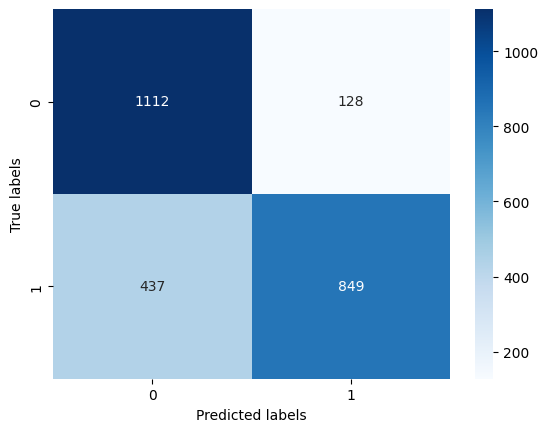

In [ ]:
cm2=confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      1240
           1       0.87      0.66      0.75      1286

    accuracy                           0.78      2526
   macro avg       0.79      0.78      0.77      2526
weighted avg       0.79      0.78      0.77      2526

